This notebook is dedicated to methods, which combine clustering and cluster-based regression models.

Firstly, We made combination of clusteing(GMM) and linear regression.
Secondly, combination of clusteing(GMM) and NN

feature_09, feature_10, feature_11 are categorical, which can be sector or some other feature to represent cluster. Thats why we compared clusters and tried to use feature_9 as cluster labels too and compare R2

In [1]:
import numpy as np
import pandas as pd
# !pip install pyro-ppl -q
import torch
# import pyro
# import pyro.distributions as dist
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import polars as pl
from sklearn.metrics import mean_squared_error
import joblib


data for validation

In [6]:
X_train = pl.scan_parquet(
         f"/kaggle/input/js2024/training.parquet/"
     ).select([f"feature_{idx:02d}" for idx in range(79)] + ['symbol_id'] + [f"responder_{idx}_lag_1" for idx in range(9)]).collect().to_pandas()

y_train = pl.scan_parquet(
         f"/kaggle/input/js2024/training.parquet/"
     ).select('responder_6').collect().to_pandas()

weights = pl.scan_parquet(
         f"/kaggle/input/js2024/training.parquet/"
     ).select('weight').collect().to_pandas()

X_val = pl.scan_parquet(
         f"/kaggle/input/js2024/validation.parquet/"
     ).select([f"feature_{idx:02d}" for idx in range(79)] + ['symbol_id'] + [f"responder_{idx}_lag_1" for idx in range(9)]).collect().to_pandas()

y_val = pl.scan_parquet(
         f"/kaggle/input/js2024/validation.parquet/"
     ).select('responder_6').collect().to_pandas()

weights_val = pl.scan_parquet(
         f"/kaggle/input/js2024/validation.parquet/"
     ).select('weight').collect().to_pandas()

In [7]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

data for training final model

In [8]:
# # joining for training full model
# X_combined = pd.concat([X_train, X_val], axis=0).reset_index(drop=True
#                                                             )
# y_combined = pd.concat([y_train, y_val], axis=0).reset_index(drop=
#                                                              True)
# weights_combined = pd.concat([weights, weights_val], axis=0).reset_index(drop=True)

In [9]:
# X_combined.columns
X_train.columns

Index(['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
       'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54',
       'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59',
       'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64',

In [10]:
# Clear validation data from memory to free up space
# import gc

# del X_train, X_val, y_train,y_val,weights,weights_val
# gc.collect()

0

In [7]:
# print(X_train['feature_09'].nunique())
# print(X_train['feature_10'].nunique())
# print(X_train['feature_11'].nunique())

In [11]:
# Clustering with Gaussian Mixture Model (GMM)
num_clusters = 3
gmm = GaussianMixture(n_components=num_clusters, random_state=42)  # Assume number clusters
gmm.fit(X_combined)
joblib.dump(gmm, 'gmm_3clusters_lags_total.pkl')

In [12]:
# from sklearn.cluster import SpectralClustering
# num_clusters = 3
# spectral = SpectralClustering(n_clusters=num_clusters, affinity='nearest_neighbors', random_state=42)
# spectral.fit(X_train)


In [13]:
# # Сохранение модели
gmm= joblib.load('/kaggle/input/gmm_3clusters_lags_total/other/gmm_3clusters_lags_total/1/gmm_3clusters_lags_total.pkl')

In [14]:
# clusters_train = gmm.predict(X_train)
clusters_test = gmm.predict(X_val)
clusters_combined = gmm.predict(X_combined.values)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GaussianMixture was fitted with feature names
  warnings.warn(


In [32]:
"""Tried to compare clusters and feature_10. 
        feature_10 не совпадает с кластерами. ARI around 0.25"""

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Исходные обозначения кластеров
true_clusters_train = X_train["feature_10"]

# Метрика ARI (Adjusted Rand Index) — устойчива к переобозначению кластеров
ari_score = adjusted_rand_score(true_clusters_train, clusters_train)

# Метрика NMI (Normalized Mutual Information) — измеряет взаимную информацию
nmi_score = normalized_mutual_info_score(true_clusters_train, clusters_train)

print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")


'Tried to compare clusters and feature_10. \n        feature_10 не совпадает с кластерами. ARI around 0.25'

In [15]:
def weighted_r2(y_true, y_pred, weights):
   
    ss_residual = np.sum(weights*(y_true - y_pred)**2)
    ss_total = np.sum(weights*(y_true)**2)
    
    # Вычисление взвешенного R2
    r2 = 1 - (ss_residual / ss_total)
    return r2

### Version 1. Linear Regression

In [17]:
# regression model for each cluster
class ClusterBasedRegression:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.models = [LinearRegression() for _ in range(num_clusters)]
    
    def fit(self, X, y, clusters):
        for cluster in range(self.num_clusters):
            # Train a separate model for each cluster
            cluster_indices = clusters == cluster
            self.models[cluster].fit(X[cluster_indices], y[cluster_indices])
    
    def predict(self, X, clusters):
        y_pred = np.zeros(X.shape[0])  # Инициализация массива предсказаний
        for cluster in range(self.num_clusters):
            cluster_indices = (clusters == cluster)
            
            # Отладка: выводим номер кластера и проверяем массив индексов
            print(f"Processing cluster {cluster}")
            print(f"Cluster indices shape: {cluster_indices.shape}, dtype: {cluster_indices.dtype}")
            
            if np.any(cluster_indices):  # Проверяем, есть ли точки в текущем кластере
                # Отладка: выводим количество точек в кластере
                print(f"Cluster {cluster}: {np.sum(cluster_indices)} samples")
                
                # Проверяем форму данных перед выборкой
                print(f"X shape: {X.shape}")
                
                X_cluster = X[cluster_indices]  # Выборка точек текущего кластера
                
                # Отладка: выводим форму выборки кластера
                print(f"X_cluster shape: {X_cluster.shape}")
                
                # Проверяем, есть ли модель для текущего кластера
                if cluster >= len(self.models):
                    raise ValueError(f"No model found for cluster {cluster}")
                
                predictions = self.models[cluster].predict(X_cluster)  # Предсказания модели
                
                # Отладка: проверяем размер предсказаний
                print(f"Predictions shape: {predictions.shape}")
                
                y_pred[cluster_indices] = predictions.ravel()  # Преобразуем в 1D и присваиваем
            else:
                print(f"Cluster {cluster} has no samples.")
        return y_pred



    def save_models(self, filepath):
        """
        Сохраняет все модели и информацию о кластерах в один файл.
        """
        data_to_save = {
            'num_clusters': self.num_clusters,
            'models': self.models  # Список обученных моделей
        }
        joblib.dump(data_to_save, filepath)
        print(f"All models saved to {filepath}")





# cluster-based regression model
cluster_model = ClusterBasedRegression(num_clusters=num_clusters)
cluster_model.fit(X_combined, y_combined, clusters_combined)


In [18]:
# joblib.dump(cluster_model, 'cluster_model_lags.pkl')

cluster_model.save_models("linear_regression_models.pkl")

All models saved to linear_regression_models.pkl


In [10]:
# Допустим, метки кластеров содержатся в фиче "feature_10"
clusters_train = X_train["feature_10"].values
clusters_test = X_val["feature_10"].values

unique_clusters = np.unique(clusters_train)
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

clusters_train = np.array([cluster_mapping[c] for c in clusters_train])
clusters_test = np.array([cluster_mapping[c] for c in clusters_test])

# Убедитесь, что количество кластеров совпадает с уникальными значениями
num_clusters = len(unique_clusters)

# модель
cluster_model = ClusterBasedRegression(num_clusters=num_clusters)
cluster_model.fit(X_train.drop("feature_10", axis=1), y_train, clusters_train)

y_pred = cluster_model.predict(X_val.drop("feature_10", axis=1), clusters_test)

NameError: name 'X_train' is not defined

In [16]:
# validation
y_pred = cluster_model.predict(X_val, clusters_test)
y_pred = np.clip(y_pred, a_min=-5, a_max=5)

mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weights_val).flatten())
print(f"Mean Squared Error: {mse}")
print(f"r2: {r2}")

Processing cluster 0
Cluster indices shape: (789888,), dtype: bool
Cluster 0: 529413 samples
X shape: (789888, 89)
X_cluster shape: (529413, 89)
Predictions shape: (529413, 1)
Processing cluster 1
Cluster indices shape: (789888,), dtype: bool
Cluster 1: 137050 samples
X shape: (789888, 89)
X_cluster shape: (137050, 89)
Predictions shape: (137050, 1)
Processing cluster 2
Cluster indices shape: (789888,), dtype: bool
Cluster 2: 123425 samples
X shape: (789888, 89)
X_cluster shape: (123425, 89)
Predictions shape: (123425, 1)
Mean Squared Error: 0.5535618832457364
r2: 0.0023369912043370578


for 3 clusters

r2: 0.00290157

for 9 clusters 

r2: r2: 0.002014902912562233

for 9 clusters from data (feature_10)

r2: -0.0009168695361476686

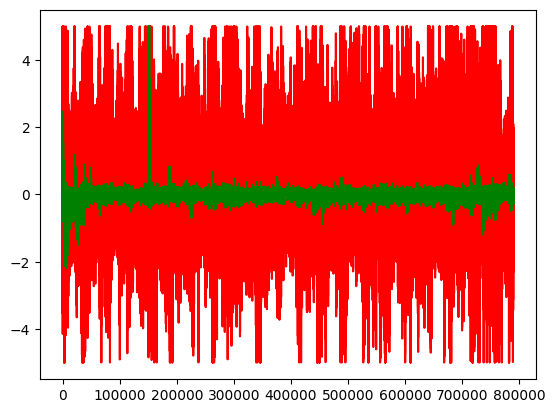

In [17]:
plt.plot(np.array(y_val).flatten(), color = 'red')
plt.plot(y_pred, color = 'green')

#### Training Linear models on all data

In [8]:
from sklearn.linear_model import LinearRegression
import numpy as np
import joblib  # Для сохранения моделей

class ClusterBasedRegression:
    def __init__(self, num_clusters):
        self.num_clusters = num_clusters
        self.models = [LinearRegression() for _ in range(num_clusters)]
    
    def fit(self, X, y, clusters):
        """
        Обучает линейные модели на объединенной выборке (train + val).
        """
        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            if not np.any(cluster_indices):  # Проверка наличия данных в кластере
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue
            # Обучение модели для текущего кластера
            self.models[cluster].fit(X[cluster_indices], y[cluster_indices])
            print(f"Cluster {cluster} model trained.")

    def predict(self, X, clusters):
        """
        Делает предсказания, используя модели для каждого кластера.
        """
        y_pred = np.zeros(X.shape[0])  # Инициализация массива предсказаний
        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            if np.any(cluster_indices):  # Проверяем, есть ли точки в текущем кластере
                X_cluster = X[cluster_indices]
                y_pred[cluster_indices] = self.models[cluster].predict(X_cluster).ravel()
            else:
                print(f"Cluster {cluster} has no samples.")
        return y_pred

    def save_models(self, filepath):
        """
        Сохраняет обученные модели и метаинформацию.
        """
        for i, model in enumerate(self.models):
            model_path = f"{filepath}_cluster_{i}.pkl"
            joblib.dump(model, model_path)
        print(f"Models saved to {filepath}_cluster_*.pkl")


In [9]:
# Получаем столбец кластеров из объединённых данных
clusters_combined = X_combined["feature_10"].values

# Преобразуем метки кластеров в последовательные индексы
unique_clusters = np.unique(clusters_combined)
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
clusters_combined = np.array([cluster_mapping[c] for c in clusters_combined])

In [10]:
# Создание модели
cluster_model = ClusterBasedRegression(num_clusters=len(unique_clusters))

# Обучение модели
cluster_model.fit(X_combined, y_combined, clusters_combined)

# Сохранение моделей
cluster_model.save_models("linear_regression_models")

Cluster 0 model trained.
Cluster 1 model trained.
Cluster 2 model trained.
Cluster 3 model trained.
Cluster 4 model trained.
Cluster 5 model trained.
Cluster 6 model trained.
Cluster 7 model trained.
Cluster 8 model trained.
Models saved to linear_regression_models_cluster_*.pkl


### Variant 2.

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, RobustScaler
import torch.nn.functional as F

In [12]:
class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob=0.3):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(negative_slope=0.01),

            nn.Linear(hidden_dim // 2, 1)  # Ensure the final layer outputs 1 value per sample
        )

    def forward(self, x):
        return self.model(x)


class ClusterBasedNNRegression:
    def __init__(self, num_clusters, input_dim, hidden_dim, learning_rate=1e-3):
        self.num_clusters = num_clusters
        self.models = [RegressionNN(input_dim, hidden_dim) for _ in range(num_clusters)]
        self.optimizers = [optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) for model in self.models]
        self.criterions = [nn.MSELoss() for _ in range(num_clusters)]
        self.scaler = RobustScaler()  # Initialize scaler

    def fit(self, X, y, clusters, epochs=50, batch_size=32):
        # Масштабируем данные
        X = self.scaler.fit_transform(X)  # Fit scaler to training data

        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(X_cluster) == 0:
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue

            if isinstance(X_cluster, pd.DataFrame):
                X_cluster = X_cluster.values
            if isinstance(y_cluster, pd.DataFrame):
                y_cluster = y_cluster.values
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
            y_tensor = torch.tensor(y_cluster, dtype=torch.float32).view(-1, 1)

            model = self.models[cluster]
            optimizer = self.optimizers[cluster]
            criterion = self.criterions[cluster]

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                output = model(X_tensor)
                loss = criterion(output, y_tensor)
                loss.backward()
                optimizer.step()

                if (epoch + 1) % 10 == 0:
                    print(f"Cluster {cluster}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    def predict(self, X, clusters):
        # Use the same scaler that was fitted during training
        X = self.scaler.transform(X)  # Transform validation data with the trained scaler
    
        y_pred = torch.zeros(X.shape[0])
    
        for cluster in range(self.num_clusters):
            # Convert cluster_indices to a PyTorch tensor
            cluster_indices = torch.tensor(clusters == cluster, dtype=torch.bool)
    
            if torch.sum(cluster_indices) == 0:
                print(f"Cluster {cluster} has no samples. Skipping prediction.")
                continue
    
            X_cluster = X[cluster_indices]
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
    
            model = self.models[cluster]
            model.eval()
    
            with torch.no_grad():
                y_pred[cluster_indices] = model(X_tensor).flatten()
    
        return y_pred.numpy()



In [10]:
# Параметры
input_dim = X_train.shape[1]  # Количество признаков

# Создаем модель
cluster_model = ClusterBasedNNRegression(num_clusters=num_clusters, input_dim=input_dim, hidden_dim=32)

# Обучаем модель
cluster_model.fit(X_train, y_train, clusters_train, epochs=10, batch_size=64)

# Предсказываем значения
y_pred = cluster_model.predict(X_val, clusters_test)
y_pred = np.clip(y_pred, a_min=-5, a_max=5)

Cluster 0, Epoch [10/10], Loss: 0.5204
Cluster 1, Epoch [10/10], Loss: 1.4314
Cluster 2, Epoch [10/10], Loss: 0.4989


In [12]:
mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weights_val).flatten())
print(f"Mean Squared Error: {mse}")
print(f"r2: {r2}")
#  - np.median(y_pred)

Mean Squared Error: 0.5623980164527893
r2: -0.014156103134155273


### Допустим, метки кластеров содержатся в фиче "feature_10"
Обучим и сохраним такую модель

In [9]:
class RegressionNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_prob=0.3):
        super(RegressionNN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(negative_slope=0.01),
            nn.Dropout(p=dropout_prob),

            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(negative_slope=0.01),

            nn.Linear(hidden_dim // 2, 1)  # Ensure the final layer outputs 1 value per sample
        )

    def forward(self, x):
        return self.model(x)


class ClusterBasedNNRegression:
    def __init__(self, num_clusters, input_dim, hidden_dim, learning_rate=1e-3):
        self.num_clusters = num_clusters
        self.models = [RegressionNN(input_dim, hidden_dim) for _ in range(num_clusters)]
        self.optimizers = [optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) for model in self.models]
        self.criterions = [nn.MSELoss() for _ in range(num_clusters)]
        self.scaler = RobustScaler()  # Initialize scaler

    def fit(self, X, y, clusters, epochs=50, batch_size=32):
        # Масштабируем данные
        X = self.scaler.fit_transform(X)  # Fit scaler to training data

        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(X_cluster) == 0:
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue

            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
            y_tensor = torch.tensor(y_cluster, dtype=torch.float32).view(-1, 1)

            model = self.models[cluster]
            optimizer = self.optimizers[cluster]
            criterion = self.criterions[cluster]

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                output = model(X_tensor)
                loss = criterion(output, y_tensor)
                loss.backward()
                optimizer.step()

                if (epoch + 1) % 10 == 0:
                    print(f"Cluster {cluster}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    def predict(self, X, clusters):
        # Use the same scaler that was fitted during training
        X = self.scaler.transform(X)  # Transform validation data with the trained scaler
    
        y_pred = torch.zeros(X.shape[0])
    
        for cluster in range(self.num_clusters):
            # Convert cluster_indices to a PyTorch tensor
            cluster_indices = torch.tensor(clusters == cluster, dtype=torch.bool)
    
            if torch.sum(cluster_indices) == 0:
                print(f"Cluster {cluster} has no samples. Skipping prediction.")
                continue
    
            X_cluster = X[cluster_indices]
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
    
            model = self.models[cluster]
            model.eval()
    
            with torch.no_grad():
                y_pred[cluster_indices] = model(X_tensor).flatten()
    
        return y_pred.numpy()

    # Метод для сохранения модели
    def save_model(self, filepath):
        for i, model in enumerate(self.models):
            model_path = f"{filepath}_cluster_{i}.pth"
            torch.save(model.state_dict(), model_path)
        # Сохранить скейлер
        joblib.dump(self.scaler, f'{filepath}_scaler.pkl')
        print(f"Models and scaler saved to {filepath}")

In [10]:
# Допустим, метки кластеров содержатся в фиче "feature_10"
clusters_train = X_train["feature_10"].values
clusters_test = X_val["feature_10"].values

unique_clusters = np.unique(clusters_train)
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

clusters_train = np.array([cluster_mapping[c] for c in clusters_train])
clusters_test = np.array([cluster_mapping[c] for c in clusters_test])

# Удаляем feature_10 из данных, чтобы она не дублировалась
X_train = X_train.drop(columns=["feature_10"])
X_val = X_val.drop(columns=["feature_10"])


NameError: name 'X_train' is not defined

In [ ]:
# Обучения на основе feature_10 as cluster
input_dim = X_train.shape[1]  # Количество признаков в данных
hidden_dim = 64  # Размер скрытого слоя
num_clusters = len(unique_clusters)  # Количество уникальных кластеров

# Создаем модель
cluster_model = ClusterBasedNNRegression(
    num_clusters=num_clusters,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    learning_rate=1e-6
)

# Преобразуем данные в массивы (если X_train и X_val – DataFrame)
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values

In [ ]:
# Обучение модели
cluster_model.fit(X_train, y_train, clusters_train, epochs=10, batch_size=32)
cluster_model.save_model("cluster_based_model")

# Предсказание
y_pred = cluster_model.predict(X_val, clusters_test)

#### for training final model

In [14]:
class ClusterBasedNNRegression:
    def __init__(self, num_clusters, input_dim, hidden_dim, learning_rate=1e-3):
        self.num_clusters = num_clusters
        self.models = [RegressionNN(input_dim, hidden_dim) for _ in range(num_clusters)]
        self.optimizers = [optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4) for model in self.models]
        self.criterions = [nn.MSELoss() for _ in range(num_clusters)]
        self.scaler = RobustScaler()  # Инициализация скейлера

    def fit(self, X, y, clusters, epochs=50, batch_size=32):
        # Масштабируем данные
        X = self.scaler.fit_transform(X)  # Применяем масштабирование к данным

        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]

            if len(X_cluster) == 0:
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue

            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
            y_tensor = torch.tensor(y_cluster, dtype=torch.float32).view(-1, 1)

            model = self.models[cluster]
            optimizer = self.optimizers[cluster]
            criterion = self.criterions[cluster]

            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()

                # Прямой проход
                output = model(X_tensor)
                loss = criterion(output, y_tensor)

                # Обратный проход
                loss.backward()
                optimizer.step()

                # Выводим информацию о процессе обучения
                if (epoch + 1) % 10 == 0:
                    print(f"Cluster {cluster}, Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

    def predict(self, X, clusters):
        # Применяем тот же скейлер, что был обучен на тренировочных данных
        X = self.scaler.transform(X)  # Применяем масштабирование к новым данным
    
        y_pred = torch.zeros(X.shape[0])
    
        for cluster in range(self.num_clusters):
            cluster_indices = torch.tensor(clusters == cluster, dtype=torch.bool)
    
            if torch.sum(cluster_indices) == 0:
                print(f"Cluster {cluster} has no samples. Skipping prediction.")
                continue
    
            X_cluster = X[cluster_indices]
            X_tensor = torch.tensor(X_cluster, dtype=torch.float32)
    
            model = self.models[cluster]
            model.eval()
    
            with torch.no_grad():
                y_pred[cluster_indices] = model(X_tensor).flatten()
    
        return y_pred.numpy()

    def save_model(self, filepath):
        for i, model in enumerate(self.models):
            model_path = f"{filepath}_cluster_{i}.pth"
            torch.save(model.state_dict(), model_path)
        # Сохранить скейлер
        joblib.dump(self.scaler, f'{filepath}_scaler.pkl')
        print(f"Models and scaler saved to {filepath}")


In [16]:
X_combined.columns

Index(['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04',
       'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20',
       'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25',
       'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30',
       'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35',
       'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40',
       'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45',
       'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50',
       'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55',
       'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60',
       'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65',

In [15]:
# Допустим, метки кластеров содержатся в фиче "feature_10"
clusters_train = X_combined["feature_10"].values

unique_clusters = np.unique(clusters_train)
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}

clusters_train = np.array([cluster_mapping[c] for c in clusters_train])

# Удаляем feature_10 из данных, чтобы она не дублировалась
X_combined = X_combined.drop(columns=["feature_10"])



KeyError: 'feature_10'

In [11]:
# Обучения на основе feature_10 as cluster
input_dim = X_train.shape[1]  # Количество признаков в данных
hidden_dim = 64  # Размер скрытого слоя
num_clusters = len(unique_clusters)  # Количество уникальных кластеров

# Создаем модель
cluster_model = ClusterBasedNNRegression(
    num_clusters=num_clusters,
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    learning_rate=1e-6
)

# Преобразуем данные в массивы (если X_train и X_val – DataFrame)
X_train = X_train.values
X_val = X_val.values
y_train = y_train.values
y_val = y_val.values



NameError: name 'X_train' is not defined

In [ ]:
# Обучение модели
cluster_model.fit(X_train, y_train, clusters_train, epochs=10, batch_size=32)
cluster_model.save_model("cluster_based_model")

# Предсказание
y_pred = cluster_model.predict(X_val, clusters_test)

Cluster 0, Epoch [10/10], Loss: 0.5390
Cluster 1, Epoch [10/10], Loss: 0.5868
Cluster 2, Epoch [10/10], Loss: 0.4373
Cluster 3, Epoch [10/10], Loss: 0.6542
Cluster 4, Epoch [10/10], Loss: 0.3599
Cluster 5, Epoch [10/10], Loss: 0.3871
Cluster 6, Epoch [10/10], Loss: 0.5040


In [19]:
mse = mean_squared_error(np.array(y_val).flatten(), y_pred)
r2 = weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weghts_val).flatten())
print(f"Mean Squared Error: {mse}")
print(f"r2: {r2}")
#  - np.median(y_pred)

Mean Squared Error: 0.07535525411367416
r2: 0.861492395401001


standart scaler

Mean Squared Error: 0.5587099194526672
r2: -0.007509946823120117

robust scaler

Mean Squared Error: 0.5567154884338379
r2: -0.002652764320373535

robust + batch = 64. epoch =10

r2: -0,0004

robust + batch = 64. epoch =20 +lags + clusters from feature

r2: 0.50119748711586

robust + batch = 64. epoch =10 +lags + clusters from feature

r2: 0.7355910837650299

robust + batch = 32. epoch =10 +lags + clusters from feature

r2: 0.861492395401001


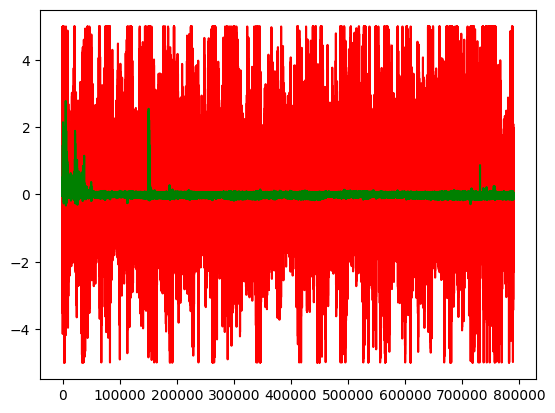

In [26]:
plt.plot(np.array(y_val).flatten(), color = 'red')
plt.plot(y_pred, color = 'green')

### Variant 4. Boosting

In [8]:
from xgboost import XGBRegressor  # Можно заменить на LightGBM или CatBoost
import numpy as np
import joblib  # Для сохранения моделей

class ClusterBasedBoosting:
    def __init__(self, num_clusters, booster_params=None):
        self.num_clusters = num_clusters
        # Инициализируем модели для каждого кластера
        self.models = [XGBRegressor(**(booster_params or {})) for _ in range(num_clusters)]
    
    def fit(self, X, y, clusters):
        """
        Обучает модели бустинга для каждого кластера.
        """
        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            if not np.any(cluster_indices):  # Проверяем, есть ли данные в текущем кластере
                print(f"Cluster {cluster} has no samples. Skipping.")
                continue
            # Обучение модели для текущего кластера
            X_cluster = X[cluster_indices]
            y_cluster = y[cluster_indices]
            self.models[cluster].fit(X_cluster, y_cluster)
            print(f"Cluster {cluster} model trained.")
    
    def predict(self, X, clusters):
        """
        Делает предсказания, используя модели для каждого кластера.
        """
        y_pred = np.zeros(X.shape[0])  # Инициализация массива предсказаний
        for cluster in range(self.num_clusters):
            cluster_indices = clusters == cluster
            if np.any(cluster_indices):  # Проверяем, есть ли данные в текущем кластере
                X_cluster = X[cluster_indices]
                y_pred[cluster_indices] = self.models[cluster].predict(X_cluster)
            else:
                print(f"Cluster {cluster} has no samples.")
        return y_pred

    def save_models(self, filepath):
        """
        Сохраняет все модели и дополнительную информацию в один файл.
        """
        data_to_save = {
            'num_clusters': self.num_clusters,
            'models': self.models  # Список моделей
        }
        joblib.dump(data_to_save, filepath)
        print(f"All models saved to {filepath}")


In [12]:
unique_clusters = np.unique(clusters_train)
cluster_mapping = {cluster: i for i, cluster in enumerate(unique_clusters)}
clusters_combined = np.array([cluster_mapping[c] for c in clusters_train])

In [ ]:
# Параметры для XGBRegressor
booster_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'learning_rate': 0.00001,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Инициализация модели
num_clusters = len(np.unique(clusters_train))
cluster_boosting_model = ClusterBasedBoosting(num_clusters=num_clusters, booster_params=booster_params)

# Обучение модели на тренировочных данных
cluster_boosting_model.fit(X_train.values, y_train.values, clusters_train)

# Предсказание на валидационных данных
y_pred = cluster_boosting_model.predict(X_val, clusters_test)

# Оценка качества модели на валидации
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_val, y_pred)
print(f"Validation Mean Squared Error: {mse:.4f}")


In [ ]:
print(f"r2: {weighted_r2(np.array(y_val).flatten(), y_pred, np.array(weights_val).flatten())}")